# Predicting Over/Under 2.5 in the Serie A 2023/2024 

## Imports

In [1]:
import pandas as pd 
import numpy as np
from team import Team, UpdateGamei
from Betting import *
from dataset import *
from Utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



C:\Users\HP\AppData\Local\Temp\ipykernel_21444\3597708908.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Prediction Function

In [22]:
def Predict(params, teams, data, mode='G'):
    """
    Predict the outcomes of future matches using logistic regression and calculate related metrics.

    Parameters:
        params (object): Object containing parameters for the prediction model.
        teams (list): List of team names.
        data (object): Object containing match data.
        mode (str): Mode of prediction. Defaults to 'G'.

    Returns:
        tuple: A tuple containing the following:
            float: The log loss of the predictions.
            ndarray: Array of predicted probabilities for all matches.
            float: The accuracy of the predictions.
            list: The cumulative profit over the betting period.
            float: The stack kelly unit.
            float: The ROI (Return on Investment).
            int: The total number of bets made.
    """
    E = np.arange(60, len(data.data) + 1, 10)
    # Update ratings
    update_ratings(params, teams, data, 60, mode, False)
    # Extract features
    X = features(params, teams, data, mode)
    # Define intervals
    intervals = np.arange(60, len(data.data) + 1, 10)
    # Initialize logistic regression model
    log_reg = LogisticRegression()
    # Get target variable
    y = data.get_y()
    # Initialize variables for betting
    all_probabilities = np.empty((0, 2))
    all_predictions = []
    T = Betting()
    # Get odds
    Under_Odds, Over_Odds = data.get_odds()
    L = []
    PROFIT = []
    # Calculate odds
    Under_Cote, Over_Cote = [1 / Under_Odds[i] for i in range(len(Over_Odds))], [1 / Over_Odds[i] for i in range(len(Under_Odds))]
    # Iterate through intervals
    for i in range(len(E) - 2):
        X_train, y_train = X[E[0] - 60: E[i + 1] - 60], y[E[0]: E[i + 1]]
        X_bet, y_bet = X[E[i + 1] - 60: E[i + 2] - 60], y[E[i + 1]: E[i + 2]]

        # Fit logistic regression model
        log_reg.fit(X_train, y_train)
        # Predict probabilities and outcomes
        probabilities = np.array(log_reg.predict_proba(X_bet))
        prediction = np.array(log_reg.predict(X_bet))
        all_probabilities = np.concatenate([all_probabilities, probabilities])
        all_predictions.extend(prediction)
        
        # Apply Kelly betting strategy
        PROFIT = T.kellybetting_unitlist(probabilities, y_bet, Over_Cote[E[i + 1] - 62: E[i + 2] - 62],
                                          Under_Cote[E[i + 1] - 62: E[i + 2] - 62], PROFIT, 0.)
        L.append(PROFIT)
    # Calculate loss and accuracy
    loss = log_loss(y[E[1]: E[len(E) - 1]], all_probabilities)
    accuracy = accuracy_score(y[intervals[1]: intervals[-1]], all_predictions)

    return loss, all_probabilities, accuracy, PROFIT/T.number_of_bets, T.stack_kelly_unit, L[-1][-1] / T.number_of_bets, T.number_of_bets



## Optimization Function: To optimize parameters to use for the next season

In [29]:
from scipy.optimize import minimize

def Optimize(lam, phi1, phi2,teams,Dataset,mode='G+S+C'):
    def objective_function(x):
        return Predict([x[0],x[1],x[2]],teams,Dataset,'G+S+C')[0]
    
    bounds = [(0.05, 2), (0.1, 0.95), (0.1, 0.95)] # set the bounds for the first three parameters
    
    result = minimize(objective_function, x0=[lam, phi1, phi2], bounds=bounds,method='nelder-mead',options={'disp': True})
    Xr=result.x
    return Xr,Predict([Xr[0],Xr[1],Xr[2]],teams,Dataset,'G+S+C')

### Data of the Season 2021/2022

In [24]:
Dataset_2122 = FootballDataset('data/SerieA_2021_2022.csv')
data_2122 = Dataset_2122.data
print(Dataset_2122.team_names())
teams_2122 = [Team(i,Dataset_2122.team_names()) for i in range(1,21)]

{1: 'Inter', 2: 'Genoa', 3: 'Verona', 4: 'Sassuolo', 5: 'Empoli', 6: 'Lazio', 7: 'Torino', 8: 'Atalanta', 9: 'Bologna', 10: 'Salernitana', 11: 'Udinese', 12: 'Juventus', 13: 'Napoli', 14: 'Venezia', 15: 'Roma', 16: 'Fiorentina', 17: 'Cagliari', 18: 'Spezia', 19: 'Sampdoria', 20: 'Milan'}


### Data of the Season 2022/2023

In [25]:
Dataset_2223 = FootballDataset('data/SerieA_2022_2023.csv')
data_2223 = Dataset_2223.data
print(Dataset_2223.team_names())
teams_2223 = [Team(i,Dataset_2223.team_names()) for i in range(1,21)]

{1: 'Milan', 2: 'Udinese', 3: 'Sampdoria', 4: 'Atalanta', 5: 'Lecce', 6: 'Inter', 7: 'Monza', 8: 'Torino', 9: 'Fiorentina', 10: 'Cremonese', 11: 'Lazio', 12: 'Bologna', 13: 'Salernitana', 14: 'Roma', 15: 'Spezia', 16: 'Empoli', 17: 'Verona', 18: 'Napoli', 19: 'Juventus', 20: 'Sassuolo'}


### Data of the Season 2023/2024

In [26]:
Dataset_2324 = FootballDataset('data/SerieA_2023_2024.csv')
data_2324 = Dataset_2324.data
print(Dataset_2324.team_names())
teams_2324 = [Team(i,Dataset_2324.team_names()) for i in range(1,21)]

{1: 'Empoli', 2: 'Verona', 3: 'Frosinone', 4: 'Napoli', 5: 'Genoa', 6: 'Fiorentina', 7: 'Inter', 8: 'Monza', 9: 'Roma', 10: 'Salernitana', 11: 'Sassuolo', 12: 'Atalanta', 13: 'Lecce', 14: 'Lazio', 15: 'Udinese', 16: 'Juventus', 17: 'Torino', 18: 'Cagliari', 19: 'Bologna', 20: 'Milan'}


### Random Initialization of the parameters for the season 2021/2022

In [20]:
loss, all_probabilities, accuracy, PROFIT_1 ,ROI,R,A= Predict([1, 0.5      , 0.5    ],teams_2122,Dataset_2122,'G+S+C')

### Profit Made in 2021/2022

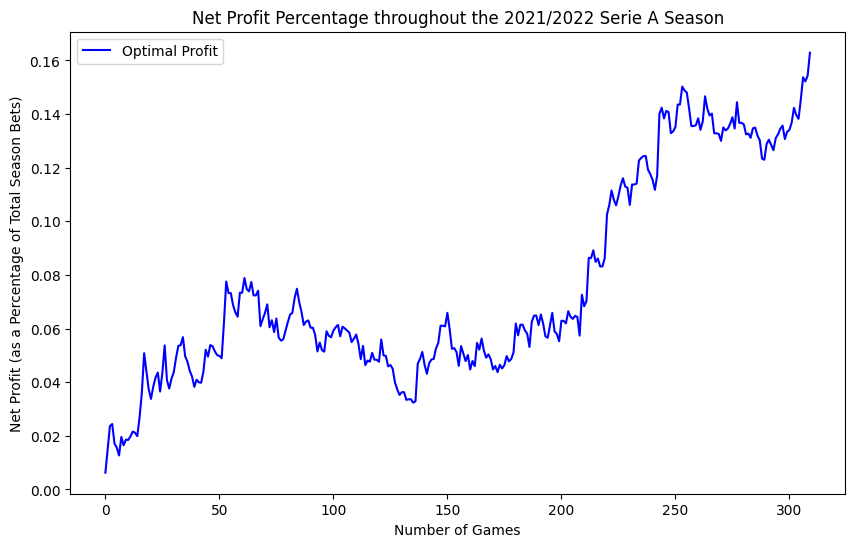

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_1)), PROFIT_1, label='Optimal Profit', color='blue')

plt.xlabel('Number of Games')
plt.ylabel('Net Profit (as a Percentage of Total Season Bets)')
plt.title('Net Profit Percentage throughout the 2021/2022 Serie A Season')
plt.legend()
plt.grid(False)
plt.show()

### Keep 2/3 of the ratings of the unreleguated season 

In [30]:
for i in range(0,20):
    if teams_2122[i].name == teams_2223[i].name:
        a,b,c,d=np.array(teams_2122[i].get())*(2/3)
        teams_2223[i].update(a,b,c,d)

### Optimize parameters for the next season 

In [10]:
Optimize(1 ,0.515,0.5,teams_2122,Dataset_2122,'G+S+C')

Optimization terminated successfully.
         Current function value: 0.689444
         Iterations: 43
         Function evaluations: 93


(array([1.01425828, 0.71686982, 0.3973806 ]),
 (0.6894438644020626,
  array([[0.37613544, 0.62386456],
         [0.3791323 , 0.6208677 ],
         [0.431926  , 0.568074  ],
         [0.3974197 , 0.6025803 ],
         [0.40115391, 0.59884609],
         [0.39095353, 0.60904647],
         [0.40705111, 0.59294889],
         [0.41989843, 0.58010157],
         [0.38538682, 0.61461318],
         [0.4144897 , 0.5855103 ],
         [0.4244216 , 0.5755784 ],
         [0.32824199, 0.67175801],
         [0.42180534, 0.57819466],
         [0.47794283, 0.52205717],
         [0.41079489, 0.58920511],
         [0.55006103, 0.44993897],
         [0.33658101, 0.66341899],
         [0.31527942, 0.68472058],
         [0.33819002, 0.66180998],
         [0.2711826 , 0.7288174 ],
         [0.3389665 , 0.6610335 ],
         [0.38740316, 0.61259684],
         [0.44768146, 0.55231854],
         [0.34029734, 0.65970266],
         [0.42840748, 0.57159252],
         [0.44263537, 0.55736463],
         [0.30455367, 

### Prediction using the optimized parameters

In [31]:
loss, all_probabilities, accuracy, PROFIT_2 ,A,B,C = Predict([1.01425828, 0.71686982, 0.3973806   ],teams_2223,Dataset_2223,'G+S+C')
print(accuracy,A,B,C,loss)

0.5161290322580645 3.7357509332741756 0.0957526098688138 39.014612117542846 0.7028786362743603


### Profit made in the season 2022/2023

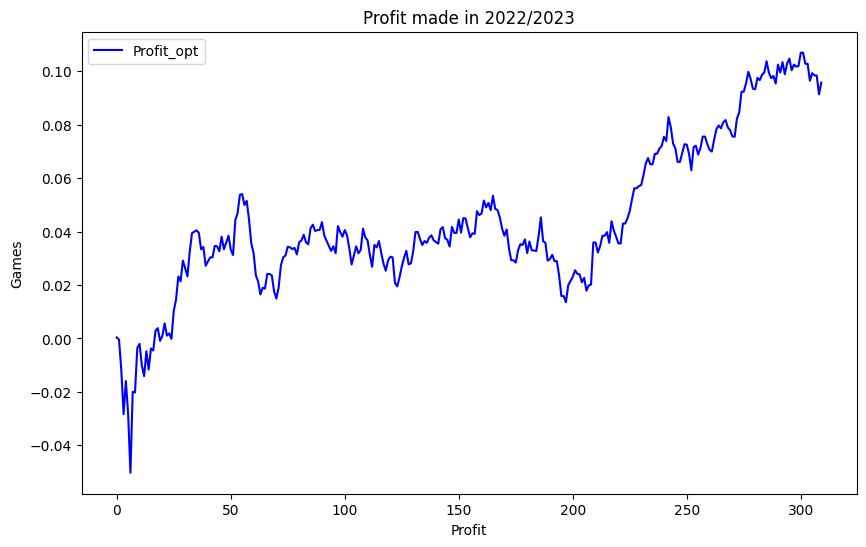

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_2)),PROFIT_2, label='Profit_opt', color='blue')

plt.xlabel('Profit')
plt.ylabel('Games')
plt.title('Profit made in 2022/2023')
plt.legend()
plt.grid(False)
plt.show()

### Keep 2/3 of the ratings of the unreleguated teams

In [33]:
for i in range(0,20):
    if teams_2223[i].name == teams_2324[i].name:
        a,b,c,d=np.array(teams_2223[i].get())*(2/3)
        teams_2324[i].update(a,b,c,d)

### Optimize parameters for the next season

In [ ]:
Optimize(1.02027191, 0.71547774, 0.40582613 ,teams_2223,Dataset_2223,'G+S+C')

### Prediction using the optimized parameters 

In [14]:
Predict([0.62339135, 0.94722871, 0.94964267   ],teams_2324,Dataset_2324,'G+S+C')

(0.7184482708628016,
 array([[0.4853193 , 0.5146807 ],
        [0.60676215, 0.39323785],
        [0.33951938, 0.66048062],
        [0.59276391, 0.40723609],
        [0.89569973, 0.10430027],
        [0.48161333, 0.51838667],
        [0.74040586, 0.25959414],
        [0.38620287, 0.61379713],
        [0.72052638, 0.27947362],
        [0.80815889, 0.19184111],
        [0.3145269 , 0.6854731 ],
        [0.23418031, 0.76581969],
        [0.76196173, 0.23803827],
        [0.47752646, 0.52247354],
        [0.26301293, 0.73698707],
        [0.4823314 , 0.5176686 ],
        [0.38180329, 0.61819671],
        [0.53000364, 0.46999636],
        [0.34716698, 0.65283302],
        [0.62188139, 0.37811861],
        [0.69227969, 0.30772031],
        [0.58633234, 0.41366766],
        [0.58706366, 0.41293634],
        [0.59803952, 0.40196048],
        [0.13351746, 0.86648254],
        [0.36680013, 0.63319987],
        [0.88741006, 0.11258994],
        [0.73142451, 0.26857549],
        [0.42908422, 0.5709

In [34]:
loss, all_probabilities, accuracy, PROFIT_3 ,_,_,_ = Predict([0.61275802, 0.94999497, 0.94914298   ],teams_2324,Dataset_2324,'G+S+C')

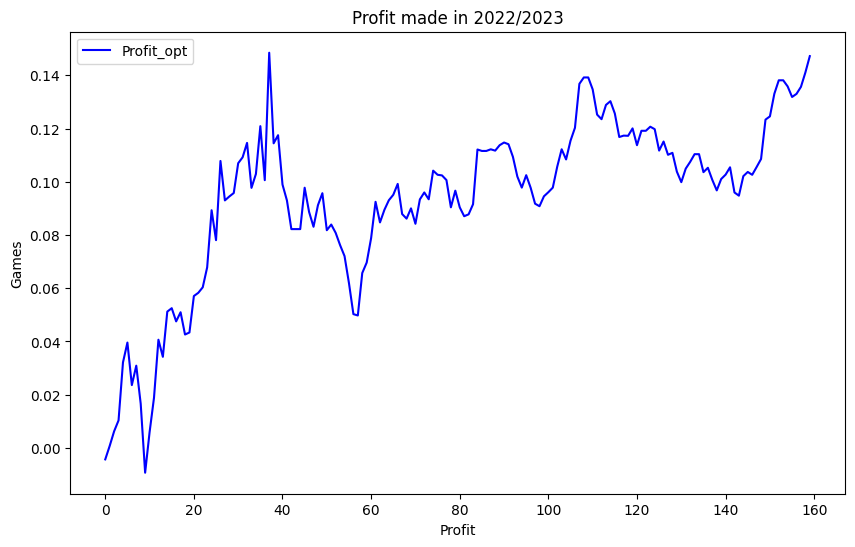

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(PROFIT_3)),PROFIT_3, label='Profit_opt', color='blue')

plt.xlabel('Profit')
plt.ylabel('Games')
plt.title('Profit made in 2022/2023')
plt.legend()
plt.grid(False)
plt.show()

In [37]:
Total_Profit = np.concatenate((PROFIT_1, PROFIT_1[-1]+PROFIT_2,PROFIT_1[-1]+PROFIT_2[-1]+PROFIT_3))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


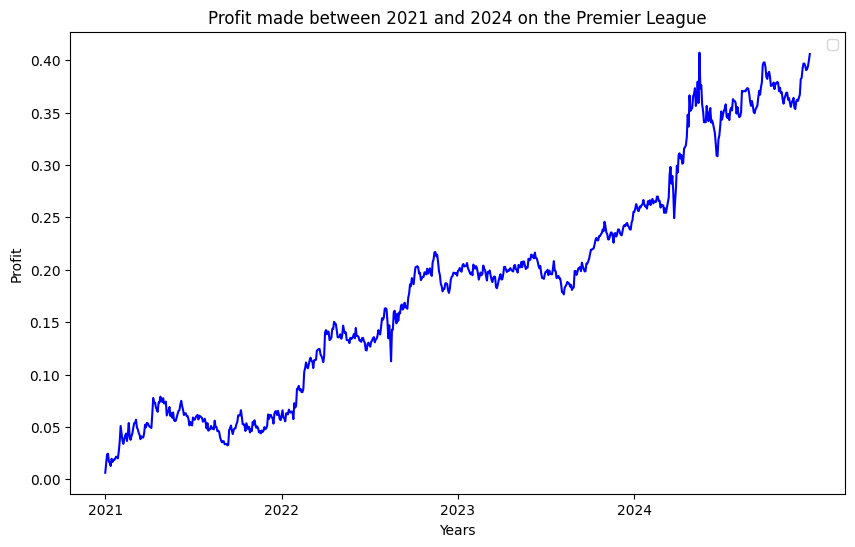

In [38]:
years = range(2021, 2025)  # Years 2022, 2023, and 2024

plt.figure(figsize=(10, 6))
plt.plot(range(len(Total_Profit)), Total_Profit, color='blue')

# Customize x-axis ticks to display years instead of game numbers
plt.xticks(range(0, len(Total_Profit), len(Total_Profit) // len(years)), years)

plt.xlabel('Years')
plt.ylabel('Profit')
plt.title('Profit made between 2021 and 2024 on the Premier League')
plt.legend()
plt.grid(False)
plt.show()

In [39]:
import pickle
with open('data/total_profit_Serie_A.pkl', 'wb') as f:
    pickle.dump(Total_Profit, f)